In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

## Keras related modules
from keras.models import Sequential, save_model, load_model
from keras.layers import Dense, Dropout, BatchNormalization
from keras import optimizers, regularizers, initializers
from keras.callbacks import ModelCheckpoint, EarlyStopping

## Sklearn related modules
from sklearn.utils import shuffle, class_weight
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

## Plot related modules
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import numpy as np
import pandas as pd

random_seed = 100
np.random.seed(random_seed)

Using TensorFlow backend.
/usr/local/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# inspired by http://nipunbatra.github.io/2014/08/latexify/
plt.style.use(['default'])
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize': 12, # fontsize for x and y labels (was 10)
    'axes.titlesize': 12,
    'font.size': 12, # was 10
    'legend.fontsize': 12, # was 10
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'text.usetex': True,
    'figure.facecolor':'white',
    'font.family': 'serif',
}
plt.rcParams.update(params)

### Import Data

In [3]:
## look data with pandas
train_file = "data/rupturemodel_train.txt"
val_file = "data/rupturemodel_xvalidate.txt"
test_file = "data/rupturemodel_test.txt"

df_train= pd.read_csv(train_file, sep=" ", header = None)
df_val= pd.read_csv(val_file, sep=" ", header = None)
df_test= pd.read_csv(test_file, sep=" ", header = None)

features_name =  ['height', 'width', 'sxx', 'sxy', 'syy', 'sdrop', 'mud', 'dc', 'label']
df_train.columns = features_name
df_val.columns = features_name
df_test.columns = features_name

df_train_all = df_train.append(df_val)

### Data processing
We use StandardScaler preprocessing method of scikit. It standardizes features 
by removing the mean and scaling to unit variance

In [4]:
df = shuffle(df_train_all, random_state = random_seed)
df_train = shuffle(df_train, random_state = random_seed)
df_val = shuffle(df_val, random_state = random_seed)
df_test = shuffle(df_test, random_state = random_seed)


mms = StandardScaler()
train_scale = mms.fit(df.drop('label', axis=1))

xtrain_all = train_scale.transform(df.drop('label', axis=1))
ytrain_all =  df['label'].values

xtrain = train_scale.transform(df_train.drop('label', axis=1))
ytrain = df_train['label'].values

xval = train_scale.transform(df_val.drop('label', axis=1))
yval = df_val['label'].values

xtest = train_scale.transform(df_test.drop('label', axis=1))
ytest = df_test['label'].values

## Pre-analysis

In [5]:
df_train_new = pd.DataFrame(xtrain, columns= features_name[:-1])
df_train_new['label'] = df_train['label']

In [6]:
df_train_all.describe()

,height,width,sxx,sxy,syy,sdrop,mud,dc,label
count,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000
mean,0.071973,1.493580,-86.124023,35.877919,-85.767890,0.393578,0.304785,0.401590,0.349375
std,0.045919,0.290491,44.589736,20.287076,41.857360,0.113716,0.087628,0.050475,0.476922
min,0.000003,1.000214,-198.643591,2.388038,-159.945235,0.200579,0.200045,0.233045,0.000000
25%,0.031667,1.242157,-120.350589,20.244549,-120.237232,0.295451,0.231681,0.367681,0.000000
50%,0.069885,1.481288,-82.773471,33.291381,-85.670660,0.389461,0.283825,0.401143,0.000000
75%,0.105252,1.743961,-50.453823,49.316321,-50.868223,0.486345,0.356399,0.434763,1.000000
max,0.195712,2.128935,-7.933036,97.618207,-10.011991,0.599913,0.573047,0.583352,1.000000


In [7]:
# g = sns.pairplot(df_train_new, hue="value", markers=["o", "s"])
# plt.xticks([-2, -1, 0, 1, 2])
# plt.show()

## Plot S-factor and shear over normal stress

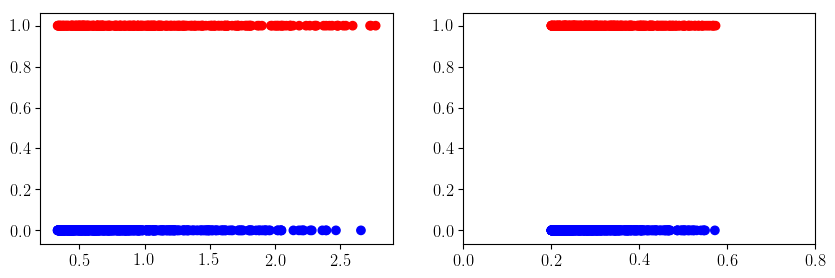

In [8]:
p lt.figure(figsize = (10, 3))
plt.subplot(1,2, 1)
plt.scatter(df_train['mud']/df_train['sdrop'], df_train['label'], c = df_train['label'], cmap = 'bwr')
plt.grid(False)

plt.subplot(1,2, 2)
plt.scatter(df_train['mud'], df_train['label'], c = df_train['label'], cmap = 'bwr')
plt.xticks([0.0, 0.2, 0.4, 0.6, 0.8])
plt.grid(False)
plt.show()

### Class distribution

In [14]:
label_count = df_train_all.groupby('label', as_index = False).count()
class_name = ['Rupture arrest', 'Rupture propagate']
count = list(label_count['height'])
print('Rupture propagate : {}, \nRupture arrest: {}'.format(count[0], count[1]))
print('Total number of data: {}'.format(np.sum(count)))
print('Class ratio for rupture propagation: {}'.format(count[0]/count[1]))

Rupture propagate : 1041, 
Rupture arrest: 559
Total number of data: 1600
Class ratio for rupture propagation: 1.8622540250447228


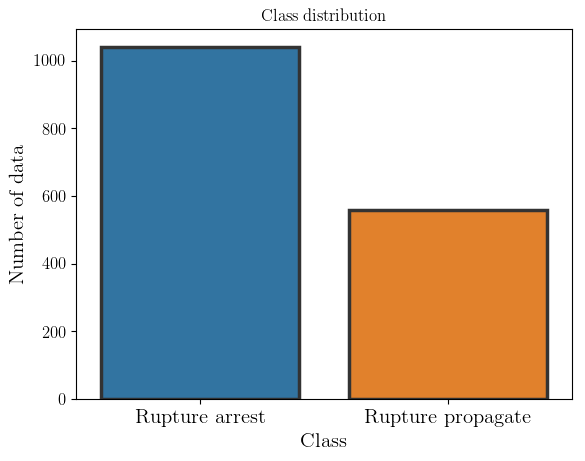

In [15]:
index = np.arange(len(class_name))
# plt.bar(class_name, count)
sns.barplot(x = class_name, y = count, linewidth = 2.5, errcolor = ".2", edgecolor = ".2")
plt.xlabel('Class', fontsize=15)
plt.ylabel('Number of data', fontsize=15)
plt.xticks(index, class_name, fontsize=15)
plt.title('Class distribution')
plt.show()

### Class weight

In [16]:
aa = class_weight.compute_class_weight('balanced', np.unique(ytrain_all.astype(int)), ytrain_all.astype(int))
CLASS_WEIGHT = {0 : aa[0] , 1: aa[1]}

In [17]:
print(CLASS_WEIGHT)

{0: 0.7684918347742555, 1: 1.4311270125223614}


## Create model

#### 1. Hyperparameters

In [18]:
HIDDEN_LAYER_SIZE = 12
L2_REGULARIZER = 5
LEARNING_RATE = 0.0025
TRAINING_EPOCHS = 2000
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.30
CLASS_WEIGHT = CLASS_WEIGHT

#### 2. Model setup

In [381]:
model = Sequential()
model.add(Dense(HIDDEN_LAYER_SIZE, 
                activation = 'relu',
                kernel_initializer = initializers.RandomNormal(mean = 0.0, stddev = 1, seed = 100),
                bias_initializer = 'Ones',
                input_shape = (8,),
                kernel_regularizer = regularizers.l2(L2_REGULARIZER),
                name = 'layer_1'))

adm_optz = optimizers.Adam(lr = LEARNING_RATE)

model.add(Dense(1, activation = "sigmoid", name = 'Output_layer'))
model.compile(optimizer = adm_optz, loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

#### 3. Train model

In [382]:
# filepath = './logs/random_seed_'+ str(random_seed) +'_{epoch:02d}.hdf5'
# checkpoint = ModelCheckpoint(filepath, verbose = 0, period = 20)
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 20)
              
callback_list = [early_stopping]

history = model.fit(xtrain_all, ytrain_all, 
                    batch_size = BATCH_SIZE, 
                    epochs = TRAINING_EPOCHS,
                    class_weight = CLASS_WEIGHT,
                    callbacks = callback_list,
                    validation_split = VALIDATION_SPLIT, 
                    verbose = 0)

## Training History

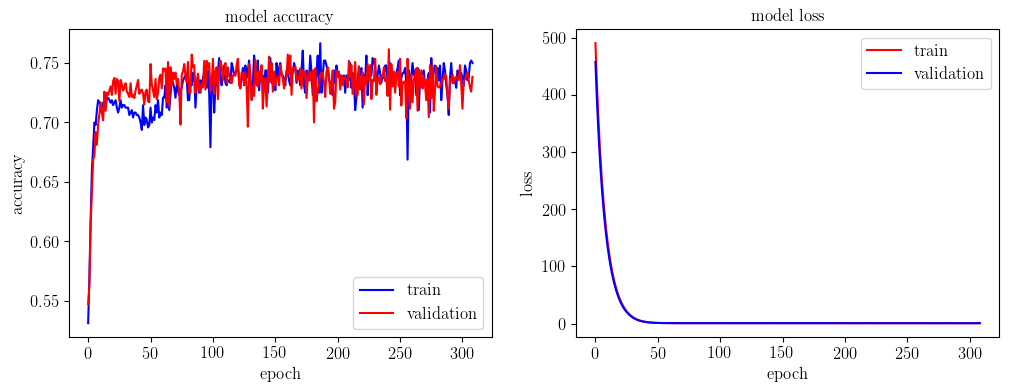

In [693]:
plt.figure(figsize= (12, 4))
# summarize history for accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['val_acc'], 'b-')
plt.plot(history.history['acc'], 'r-')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')

# summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], 'r-')
plt.plot(history.history['val_loss'], 'b-')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## Threshold analysis based on training data'

In [384]:
ypred_train = model.predict(xtrain_all)

In [385]:
from sklearn.metrics import roc_auc_score, roc_curve
roc_auc_score = roc_auc_score(ytrain_all, ypred_train)
fpr, tpr, thresholds = roc_curve(ytrain_all, ypred_train, pos_label = 1)

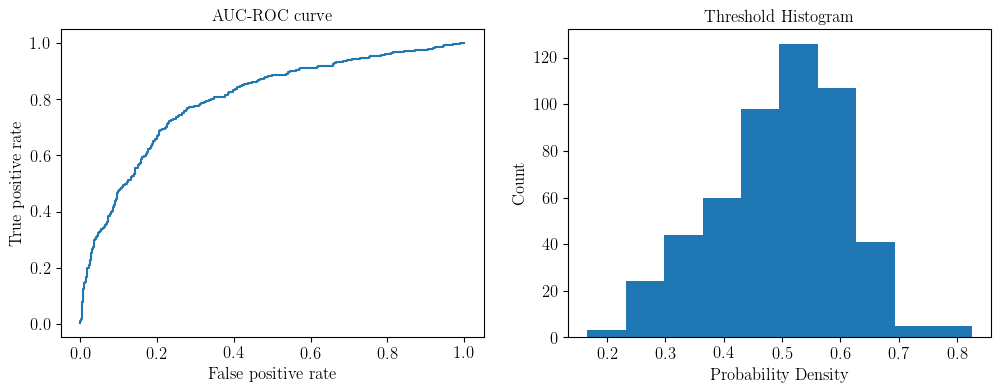

In [694]:
plt.figure(figsize=(12, 4))
plt.subplot(1,2, 1)
plt.plot(fpr, tpr)
plt.title('AUC-ROC curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

plt.subplot(1, 2, 2)
plt.hist(thresholds)
plt.title('Threshold Histogram')
plt.xlabel('Probability Density')
plt.ylabel('Count')
plt.show()

In [387]:
def prediction(xdata, ydata, threshold = 0.50):
    ypred_test_prob = model.predict(xdata)
    ypred_bin = [1.0 if val > threshold  else 0.0 for val in ypred_test_prob]
    print('Accuracy of the model: {}\n'.format(accuracy_score(ydata, ypred_bin)))
    print('Classification report: \n{}\n'.format(classification_report(ydata, ypred_bin)))
    print('Confusion matrix: \n{}\n'.format(confusion_matrix(ydata, ypred_bin)))
    return ypred_bin

In [388]:
THRESHOLD = np.median(thresholds)
print(THRESHOLD)

0.5100242


## Training data prediction

In [389]:
prediction(xtrain_all, ytrain_all, threshold = THRESHOLD)

Accuracy of the model: 0.75625

Classification report: 
             precision    recall  f1-score   support

        0.0       0.83      0.79      0.81      1041
        1.0       0.64      0.69      0.66       559

avg / total       0.76      0.76      0.76      1600


Confusion matrix: 
[[826 215]
 [175 384]]



## Test data prediction

In [393]:
prediction(xtest, ytest, threshold = 0.50)

Accuracy of the model: 0.8125

Classification report: 
             precision    recall  f1-score   support

        0.0       0.90      0.82      0.86       272
        1.0       0.68      0.80      0.73       128

avg / total       0.83      0.81      0.82       400


Confusion matrix: 
[[223  49]
 [ 26 102]]



### Save model:

In [394]:
filename = './logs/rupture_best_model.h5'
model.save(filename)

### Get loaded model

In [12]:
model_weights = []
filename = './logs/rupture_best_model.h5'

loaded_model = load_model(filename)

weights = loaded_model.get_weights()

layer_1_weights = weights[0]    
layer_2_weights = weights[2]

In [13]:
loaded_test_prob = loaded_model.predict(xtest)
ypred_bin = [1.0 if val > 0.5  else 0.0 for val in loaded_test_prob]
print('Accuracy of the model: {}\n'.format(accuracy_score(ytest, ypred_bin)))
print('Classification report: \n{}\n'.format(classification_report(ytest, ypred_bin)))
print('Confusion matrix: \n{}\n'.format(confusion_matrix(ytest, ypred_bin)))

Accuracy of the model: 0.8125

Classification report: 
             precision    recall  f1-score   support

        0.0       0.90      0.82      0.86       272
        1.0       0.68      0.80      0.73       128

avg / total       0.83      0.81      0.82       400


Confusion matrix: 
[[223  49]
 [ 26 102]]



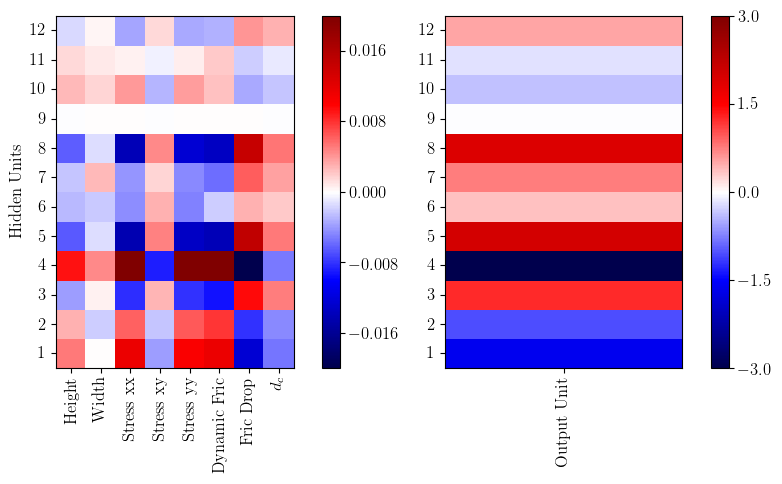

In [15]:
# %matplotlib notebook

from matplotlib import ticker

plt.figure(figsize=(8, 5))

plt.subplot(1,2, 1)
aa = np.transpose(layer_1_weights)
plt.pcolormesh(aa, cmap = 'seismic', vmin = -0.02, vmax = 0.02)
labels = ['Height', 'Width', 'Stress xx', 'Stress xy', 'Stress yy', 'Dynamic Fric', 'Fric Drop', '$d_c$']

plt.xticks([0.5+float(x) for x in range(0,8)], labels, rotation='vertical')
plt.yticks([0.5+float(x) for x in range(0,12)], list(range(1,13)))
plt.ylabel('Hidden Units')

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.35)

cb = plt.colorbar(orientation="vertical",fraction=0.07, pad=0.1)
tick_locator = ticker.MaxNLocator(nbins=5)
cb.locator = tick_locator
cb.update_ticks()

# Layer two plot
plt.subplot(1, 2, 2)
bb = np.reshape(layer_2_weights, (12, 1))
plt.pcolormesh(bb, cmap = 'seismic', vmin = -3.0, vmax = 3.0)
plt.xticks([0.5],['Output Unit'],rotation='vertical')
plt.yticks([0.5+float(x) for x in range(0,12)], list(range(1,13)))
cb = plt.colorbar(orientation="vertical",fraction=0.07, pad=0.1)
tick_locator = ticker.MaxNLocator(nbins=5)
cb.locator = tick_locator
cb.update_ticks()

plt.tight_layout()
# plt.savefig('weight_vs_features.eps')
plt.show()


### Error ananlysis on test data

#### 1. Identify true positive, negative, false positive and negative

In [16]:
def get_classified_classes(xdata, ydata, ypred):
    true_positive = []
    true_negative = []
    false_positive = []
    false_negative = []

    yval_new = list(yval)

    for i in range(len(ydata)):
        aa = list(xdata[i,:])
        aa.append(ydata[i])

        if ydata[i] == 0 and ypred[i] == 1:
            false_positive.append(np.array(aa))
        elif ydata[i] == 1 and ypred[i] == 0:
            false_negative.append(np.array(aa))
        elif ydata[i] == 0 and ypred[i] == 0:
            true_negative.append(np.array(aa))
        elif ydata[i] == 1 and ypred[i] == 1:
            true_positive.append(np.array(aa))

    df_true_positive = pd.DataFrame(true_positive, columns = features_name)
    df_true_negative = pd.DataFrame(true_negative, columns = features_name)
    df_false_positive = pd.DataFrame(false_positive, columns = features_name)
    df_false_negative = pd.DataFrame(false_negative, columns = features_name)
    
    df_true_positive['label'] = 1
    df_true_negative['label'] = 2
    df_false_positive['label'] = 3
    df_false_negative['label'] = 4
    
    frames = [df_true_positive, df_true_negative, df_false_positive, df_false_negative]
    df_all = pd.concat(frames)
    
    return df_all

#### 3. PCA dimension reduction

In [17]:
pred_train_all_prob = loaded_model.predict(xtrain_all)
ypred_bin_all = [1.0 if val > 0.5  else 0.0 for val in pred_train_all_prob]
df_classified = get_classified_classes(xtrain_all, ytrain_all, ypred_bin_all)

In [18]:
embedded = PCA(n_components=2, random_state = 2018).fit_transform(df_classified.drop('label', axis=1))
color_label = np.array(df_classified['label'])

In [19]:
nn_pca = np.append(embedded, np.reshape(color_label, (1600, 1)), axis = 1)

#### 4. Plot PCA components

In [20]:
file = open('rf_pca_data.pkl', 'rb')
rf_pca = pickle.load(file)

In [21]:
labels = ['Height', 'Width', 'Stress xx', 'Stress xy', 'Stress yy', 'Dynamic Fric', 'Fric Drop', '$d_c$']
grouped_data = np.array(df_classified.groupby('label').mean())

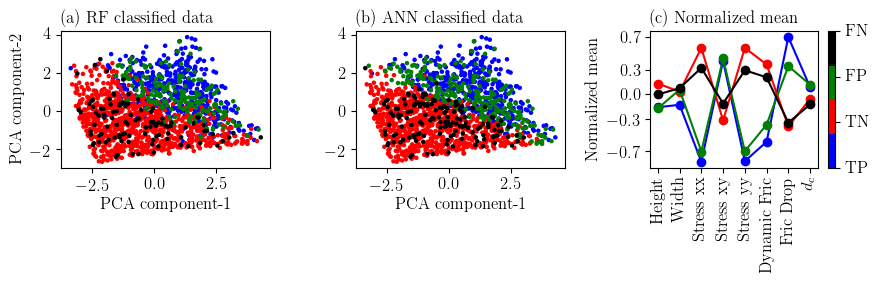

In [64]:
import matplotlib as mpl
colors = ['blue', 'red', 'green', 'black']
cmap = mpl.colors.ListedColormap(colors)

fig = plt.figure(figsize=(9, 3))

ax1 = fig.add_subplot(1, 3, 1)
ax1.scatter(rf_pca[:, 0], rf_pca[:, 1], c = rf_pca[:, 2], cmap = cmap, s = 5)
ax1.set_xlabel('PCA component-1')
ax1.set_ylabel('PCA component-2')
ax1.set_title('(a) RF classified data',  loc='left')

ax2 = fig.add_subplot(1, 3, 2)
sct = ax2.scatter(nn_pca[:, 0], nn_pca[:, 1], c = nn_pca[:, 2], cmap = cmap, s = 5)
ax2.set_xlabel('PCA component-1')
ax2.set_title('(b) ANN classified data', loc='left')

ax3 = fig.add_subplot(1, 3, 3)
ax3.plot([1, 2, 3, 4, 5, 6, 7, 8], grouped_data[0, :], '-o', c = colors[0])
ax3.plot([1, 2, 3, 4, 5, 6, 7, 8], grouped_data[1, :], '-o', c = colors[1])
ax3.plot([1, 2, 3, 4, 5, 6, 7, 8], grouped_data[2, :], '-o', c = colors[2])
ax3.plot([1, 2, 3, 4, 5, 6, 7, 8], grouped_data[3, :], '-o', c = colors[3])
ax3.set_xticks([1.0 + float(x) for x in range(0,8)])
ax3.set_ylabel('Normalized mean')
ax3.set_title('(c) Normalized mean', loc='left')

ax3.set_xticklabels(labels, rotation='vertical')
ax3.set_yticks([-0.7, -0.3, 0.0, 0.3, 0.7])

# cax = plt.axes([0.99, 0.41, 0.01, 0.46])

cbar = fig.colorbar(sct, orientation = 'vertical', 
                    ticks=[1, 2, 3, 4])
cbar.ax.set_yticklabels(['TP', 'TN', 'FP', 'FN'])

# plt.subplots_adjust(left=None, bottom=None, right=20, top=None,
#                 wspace=0, hspace=1.0)

plt.tight_layout()
plt.savefig('misclassified_data.eps')
plt.show()

## Plot flatten weights heatmap

In [8]:
flatten_weights = []
for i in range(len(random_seed)):
    filename = './logs/random_seed_'+ str(random_seed[i])+'_999.hdf5'
    loaded_model.load_weights(filename)
    weights = loaded_model.get_weights()
    layer_1_weights = weights[0]
    layer_1_weights = layer_1_weights.flatten()
    flatten_weights.append(layer_1_weights)

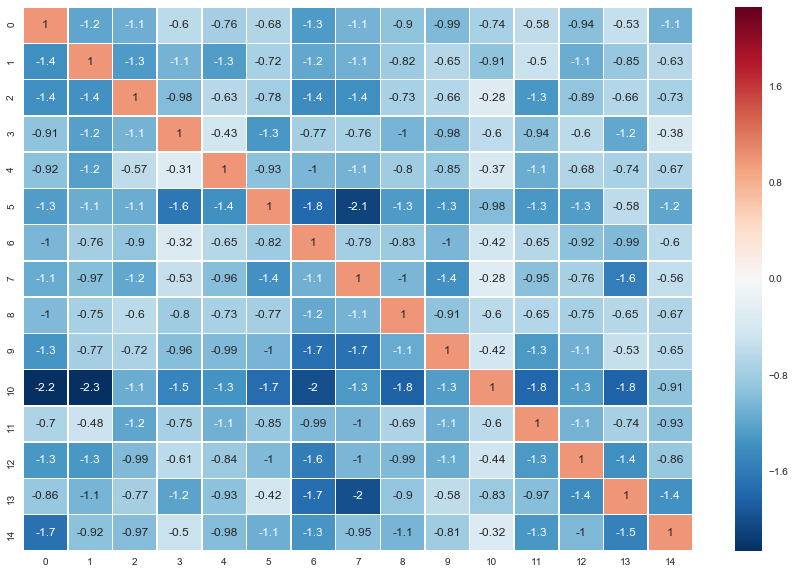

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
sns.set()

# Calculate r2_matrix
length = len(random_seed)
r2_matrix = np.zeros((length, length))
for i in range(length):
    for j in range(length):
        r2_matrix[i][j] = r2_score(flatten_weights[i], flatten_weights[j])

# Plot
# mask = np.ones_like(corr)
# mask[np.triu_indices_from(mask, 1)] = False
# mask=mask
f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(r2_matrix, annot=True, linewidths=.5)
plt.savefig('unsorted_corr.eps')

## plot sorted weight heatmap

In [60]:
flatten_weights = []
for i in range(len(random_seed)):
    filename = './logs/random_seed_'+ str(random_seed[i])+'_999.hdf5'
    loaded_model.load_weights(filename)
    weights = loaded_model.get_weights()
    layer_1_weights = weights[0]
    layer_1_weights = np.sort(layer_1_weights.flatten())
    flatten_weights.append(layer_1_weights)

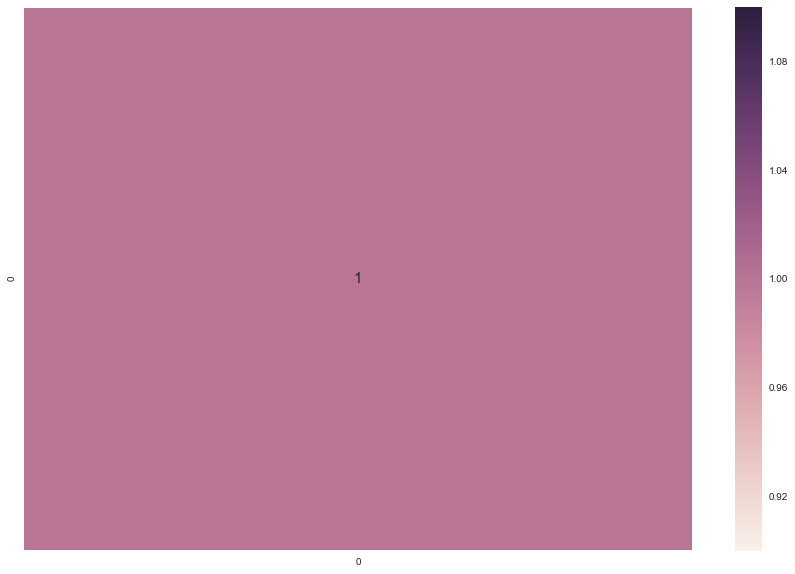

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
sns.set()

# Calculate r2_matrix
length = len(random_seed)
r2_matrix = np.zeros((length, length))
for i in range(length):
    for j in range(length):
        r2_matrix[i][j] = r2_score(flatten_weights[i], flatten_weights[j])

# Plot
plt.rcParams.update({'font.size': 15})
f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(r2_matrix, annot=True, linewidths=.5)
plt.savefig('sorted_corr.eps')

## Prediction for different seed based models

In [15]:
from sklearn.metrics import precision_score, f1_score, fbeta_score, recall_score

score_f1 = []
score_precision = []
score_fbeta = []
score_recall = []

for i in range(len(random_seed)):
    filename = './logs/random_seed_'+ str(random_seed[i])+'_999.hdf5'
    loaded_model.load_weights(filename)
    Y_pred = loaded_model.predict(X_test)
    Y_test_class = np.argmax(Y_test, axis = 1)
    Y_pred_class = np.argmax(Y_pred, axis = 1)
    score_precision.append(precision_score(Y_test_class, Y_pred_class))
    score_f1.append(f1_score(Y_test_class, Y_pred_class))
    score_fbeta.append(fbeta_score(Y_test_class, Y_pred_class, 0.5))
    score_recall.append(recall_score(Y_test_class, Y_pred_class))

## Plot different evaluation metric

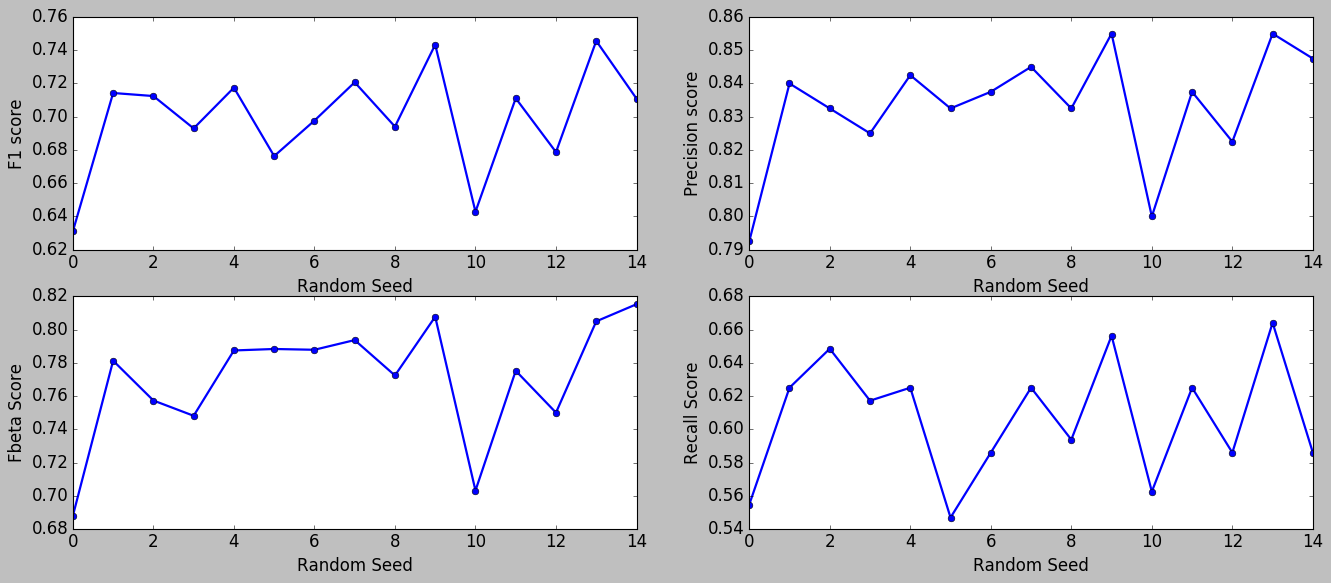

In [18]:
# plt.style.use('classic')
plt.rcParams.update({'font.size': 15})
plt.rc('lines', linewidth=2, color='k')
plt.figure(figsize=(20,8))

metric = [score_f1, score_acc, score_fbeta, score_recall]
ylabel = ['F1 score', 'Precision score', 'Fbeta Score', 'Recall Score']

for i in range(4):
    plt.subplot(2,2, i+1)
    plt.plot(metric[i], '-o')
    plt.xlabel('Random Seed')
    plt.ylabel(ylabel[i])
plt.savefig('scores.eps')
plt.show()

In [15]:
weight_mean =[]
weight_max =[]
weight_min =[]
for i in range(len(model_weights)):
    x = np.matrix(model_weights[i])
    weight_mean.append(x.mean())
    weight_max.append(x.max())
    weight_min.append(x.min())

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(weight_mean, '-r')

plt.subplot(1,3,2)
plt.plot(weight_max, '-k')

plt.subplot(1,3,3)
plt.plot(weight_min, '-b')
plt.show()
    

NameError: name 'model_weights' is not defined

In [71]:
Y_pred = loaded_model.predict(X_test)
Y_test_class = np.argmax(Y_test, axis = 1)
Y_pred_class = np.argmax(Y_pred, axis = 1)

In [72]:
print(accuracy_score(Y_test_class, Y_pred_class))
print(classification_report(Y_test_class, Y_pred_class))
print('---------- Confusion matrix ----------')
confusion_matrix(Y_test_class, Y_pred_class)

0.8475
             precision    recall  f1-score   support

          0       0.83      0.97      0.90       272
          1       0.90      0.59      0.71       128

avg / total       0.86      0.85      0.84       400

---------- Confusion matrix ----------


array([[264,   8],
       [ 53,  75]])

## Plot accuracy 

In [44]:
#print(history.history.keys())

plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(20,5))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy', size=16)
plt.ylabel('Accuracy', size=16)
plt.xlabel('Epoch', size=16)
plt.legend(['Training', 'Validation'], loc='lower right')


NameError: name 'history' is not defined

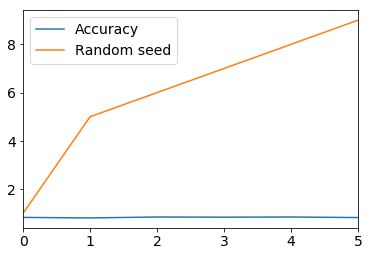

In [45]:
# model accuracy at different random seed
data = pd.DataFrame({'Random seed':[1, 5, 6, 7, 8, 9],
                     'Accuracy' : [0.8275, 0.8075, 0.845, 0.8375, 0.845, 0.8225]})
data.plot()

### best seed model

In [ ]:
random_seed = 100